# Preface to this document:
This document can be used to replicate the experiments included in the ICML submission "LUNCH: Learning from Unlabeled Nodes in a Clustering Hierarchy". Please be aware that this code is not for distribution, personal use (aside from replicating the experiments for the purpose of review), or inspiration until this work is published. Please delete this and all related files upon conclusion of review.

All class definitions and algorithms not available through common imported packages are in this file for the purpose of increasing simplicity and transparency - after executing these definitions, the experiments of interest are at the end of the file. There will be four major sections:
- UnionFind/DisjointSet Definition and Statistical Utilities
- Euclidean Minimum Spanning Tree algorithms
- LUNCH definitions
- Performance and Runtime Experiments

# Section 1: Imports, UnionFind, and Statistical Utilities

In [1]:
import numpy as np
import math
from copy import copy
import timeit
import matplotlib.pyplot as plt
import pickle

In [2]:
# Series Statistics: Utilities
def mean_sd_se(list_of_values):
    mean = sum(list_of_values)/max(1, len(list_of_values))
    var = sum([(value - mean)*(value - mean) for value in list_of_values])/max(1, len(list_of_values))
    std_dev = math.sqrt(var)
    std_err = std_dev/math.sqrt(max(1, len(list_of_values)))
    return (mean, std_dev, std_err)

def series_statistics(list_of_lists):
    means = []
    std_devs = []
    std_errs = []
    for list_of_values in list_of_lists:
        (mean, sd, se) = mean_sd_se(list_of_values)
        means.append(mean)
        std_devs.append(sd)
        std_errs.append(se)
    return (means, std_devs, std_errs)

In [3]:
def squared_euclidean_distance(vector1, vector2):
    difference = vector1 - vector2
    return difference.dot(difference.T)

sed = squared_euclidean_distance

def euclidean_distance(vector1, vector2):
    return math.sqrt(sed(vector1, vector2))

In [4]:
"""UnionFind.py
Adapted from https://www.ics.uci.edu/~eppstein/PADS/UnionFind.py accessed on August 1, 2017

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.

___

Further alterations by Sam Saarinen.
Notably, Child-Set Caching for fast set lookup
and union by rank, which has better asymptotic guarantees.
"""

from copy import copy

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.ranks = {}
        self.weights = {}
        self.parents = {}
        self.children = {}
        self.labels = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.children[object] = [object]
            self.ranks[object] = 0  # This serves as an upper bound on the depth of the paths
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.ranks[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.ranks[heaviest] = max(self.ranks[heaviest], self.ranks[r]+1)
                self.weights[heaviest] = self.weights[heaviest] + self.weights[r]
                self.children[heaviest].extend(self.children[r])
                self.parents[r] = heaviest
    
    def sets(self):
        parent_sets = {}
        for key in self.parents:
            parent = self[key]
            if parent in parent_sets:
                parent_sets[parent].append(key)
            else:
                parent_sets[parent] = [key]
        return parent_sets
    
    def weight(self, object):
        return self.weights[self[object]]  # Gives the size of the connected component
    
    def component_set(self, element):
        component = self[element]
        return copy(self.children[component])

# Section 2: EMST Algorithms

In [5]:
# Kruskal's algorithm is the fastest for high-dimensional data (>10 dimensions)
def brute_kruskal(data_matrix, metric=sed):
    # A correctness baseline that returns the MST
    indices = range(len(data_matrix))
    all_edges = []
    for i in indices:
        for j in range(i+1, len(data_matrix)):
            all_edges.append((i,j))
    all_edges.sort(key=lambda edge :metric(data_matrix[edge[0]], data_matrix[edge[1]]))
    components = UnionFind()
    for i in indices:
        components[i]
    edge_set = []
    for edge in all_edges:
        i = edge[0]
        j = edge[1]
        if components[i] != components[j]:
            edge_set.append(edge)
            components.union(i,j)
    return edge_set

def total_weight(data_matrix, edge_set):
    # Can compute the total tree weight for an MST
    return sum([euclidean_distance(data_matrix[edge[0]], data_matrix[edge[1]]) for edge in edge_set])

In [6]:
# An edge representation standardizer
def canonical(i, j):
    if i < j:
        return (i,j)
    else:
        return (j, i)

In [7]:
class HyperBox():
    def __init__(self, data_matrix, indices, dist=sed):
        self.data_matrix = data_matrix  # A numpy matrix
        self.indices = indices  # A list
        self.index_to_data = {indices[i]:self.data_matrix[i,:] for i in range(len(indices))}
        self.dist = dist
        self.center = self.find_closest(self.mean())
        self.mins = np.amin(self.data_matrix, 0)
        self.maxs = np.amax(self.data_matrix, 0)
    
    def find_closest(self, query_data):
        return min(self.indices, key=lambda index : self.dist(self.index_to_data[index], query_data))
    
    def mean(self):
        sums = np.sum(self.data_matrix, 0)
        return sums / len(self.data_matrix)
    
    #def center(self):
    #    return self.find_closest(self.mean())
    
    def max_var(self):
        variances = np.var(self.data_matrix, 0)
        return max(list(range(len(variances))), key= lambda index: variances[index])
    
    #def mins(self):
    #    return np.amin(self.data_matrix, 0)
    
    #def maxs(self):
    #    return np.amax(self.data_matrix, 0)
    
    def split(self, dim):
        # returns two HyperBoxes with half the range along specified dimension
        half_point = (self.mins + (self.maxs-self.mins) * .5)[dim]  # TODO: check other midpoints - mean, median (fast alg at Fast Computation of the Median by Successive Binning)
        join_indices = np.array(self.indices).reshape(len(self.indices), 1)
        joint_matrix = np.append(self.data_matrix, join_indices, 1)
        part1 = joint_matrix[joint_matrix[:,dim]<=half_point,:]
        part2 = joint_matrix[joint_matrix[:,dim]>half_point,:]
        hb1 = HyperBox(part1[:,0:-1], part1[:,-1:].astype(int).flatten(), self.dist)
        hb2 = HyperBox(part2[:,0:-1], part2[:,-1:].astype(int).flatten(), self.dist)
        return (hb1, hb2)
    
    def max_var_split(self):
        return self.split(self.max_var())
    
    def nearest_possible_point(self, data_vector):
        lower_bounded = np.amax(np.append(self.mins, data_vector, 0), 0)
        upper_bounded = np.amin(np.append(self.maxs, data_vector, 0), 0)
        return upper_bounded
    
    def nearest_possible_dist(self, data_vector):
        return self.dist(data_vector, self.nearest_possible_point(data_vector))
    
    def dist_to_other(self, some_hyper_box):
        distances = []
        for index in range(len(self.mins)):
            if self.mins[index] > some_hyper_box.maxs[index]:
                distances.append(self.mins[index]-some_hyper_box.maxs[index])
            elif some_hyper_box.mins[index] > self.maxs[index]:
                distances.append(some_hyper_box.mins[index] - self.maxs[index])
            else:
                distances.append(0)
        return self.dist(np.array([0 for point in self.mins]), np.array(distances))

In [8]:
class HyperBoxTree():
    def __init__(self, hyper_box):
        self.hyper_box = hyper_box
        self.children = []
        HyperBoxTree.build_tree(self)  # NOTE: This actually does a ton of redundant computation. Do not do this.
        self.has_unanimous_label = False  # Used by dual-tree boruvka
        self.unanimous_label = -1  # A value never used by UnionFind.
    
    def __str__(self):
        return str(self.hyper_box.indices) + " Unanimous?: " + str(self.has_unanimous_label) + " label: " + str(self.unanimous_label)
    
    def build_tree(hyper_box_tree):
        if len(hyper_box_tree.hyper_box.data_matrix) <= 1:
            return hyper_box_tree
        else:
            new_box1, new_box2 = hyper_box_tree.hyper_box.max_var_split()
            tree1 = HyperBoxTree(new_box1)
            tree2 = HyperBoxTree(new_box2)
            hyper_box_tree.children = [tree1, tree2]
            return hyper_box_tree
    
    def update_unanimous_label(self, components):  # Returns true if this now has a unanimous label.
        if len(self.hyper_box.data_matrix) <= 1:
            self.has_unanimous_label = True
            self.unanimous_label = components[self.hyper_box.center]
            return True
        else:
            all_children_unanimous = True
            for child in self.children:
                all_children_unanimous = child.update_unanimous_label(components) and all_children_unanimous  # Python's shortcutting cause incomplete recursion in the opposite order.
            if all_children_unanimous:
                if self.children[0].unanimous_label == self.children[1].unanimous_label:  # Assumes binary tree
                    self.has_unanimous_label = True
                    self.unanimous_label = self.children[0].unanimous_label
                    return True
            return False
    
    def count_unanimous(self):  # Debugging
        total = 0
        if self.has_unanimous_label:
            total = 1
        for child in self.children:
            total = total + child.count_unanimous()
        return total
    
    def max_depth(self):
        if len(self.hyper_box.data_matrix) <= 1:
            return 1
        else:
            return 1 + max([child.max_depth() for child in self.children])
    
    # Helper method used by suggest_edges.
    def find_diff_label_child(self, components, label):
        new_index = None
        if self.children[0].has_unanimous_label and self.children[0].unanimous_label != label:
            new_index = self.children[0].hyper_box.center
            return new_index
        elif self.children[1].has_unanimous_label and self.children[1].unanimous_label != label:
            new_index = self.children[1].hyper_box.center
            return new_index
        elif not self.children[0].has_unanimous_label:
            new_index = self.children[0].find_diff_label_child(components, label)
            return new_index
        else:
            new_index = self.children[1].find_diff_label_child(components, label)
            return new_index
    
    # This (unfortunately verbose) utility suggests nearby points in the HyperBoxTree as possible nearest neighbors.
    # By calling this ~O(n) algorithm before each Boruvka step in fast_EMST below, we prune much larger portions
    #   of the search space, especially after the first iteration.
    def suggest_edges(self, components, c_distances=None, q_distances=None, edges_in_progress=None):  # TODO: Improve Heuristic
        if c_distances is None:
            c_distances = {}
        if q_distances is None:
            q_distances = {}
        if edges_in_progress is None:
            edges_in_progress = {}
        # print(len(c_distances), len(q_distances), len(edges_in_progress))  # Debugging
        if self.has_unanimous_label:  # Base case: No internal edges to form.
            return c_distances, q_distances, edges_in_progress
        else:  # Some edges can be suggested among children
            if self.children[0].has_unanimous_label or self.children[1].has_unanimous_label:
                if self.children[0].has_unanimous_label and self.children[1].has_unanimous_label:
                    c0 = self.children[0].hyper_box.center
                    c1 = self.children[1].hyper_box.center
                    for index in self.children[0].hyper_box.indices:
                        dist = self.hyper_box.dist(self.hyper_box.index_to_data[index], self.hyper_box.index_to_data[c1])
                        if (components[index] not in c_distances) or (c_distances[components[index]] > dist):
                            c_distances[components[index]]=dist
                            edges_in_progress[components[index]]=canonical(index, c1)
                    q_distances[self.children[0]] = c_distances[components[c0]]
                    for index in self.children[1].hyper_box.indices:
                        dist = self.hyper_box.dist(self.hyper_box.index_to_data[index], self.hyper_box.index_to_data[c0])
                        if (components[index] not in c_distances) or (c_distances[components[index]] > dist):
                            c_distances[components[index]]=dist
                            edges_in_progress[components[index]]=canonical(index, c0)
                    q_distances[self.children[1]] = c_distances[components[c1]]
                    # q_distances have been set in children and can be propagated.
                    q_distances[self] = max([q_distances[self.children[0]], q_distances[self.children[1]]])
                    return c_distances, q_distances, edges_in_progress
                    
                elif self.children[0].has_unanimous_label:
                    c0 = self.children[0].hyper_box.center
                    c1 = self.children[1].find_diff_label_child(components, self.children[0].unanimous_label)
                    for index in self.children[0].hyper_box.indices:
                        dist = self.hyper_box.dist(self.hyper_box.index_to_data[index], self.hyper_box.index_to_data[c1])
                        if (components[index] not in c_distances) or (c_distances[components[index]] > dist):
                            c_distances[components[index]]=dist
                            edges_in_progress[components[index]]=canonical(index, c1)
                    q_distances[self.children[0]] = c_distances[components[c0]]
                    
                    c_distances, q_distances, edges_in_progress = self.children[1].suggest_edges(components, c_distances, q_distances, edges_in_progress)
                    # q_distances have been set in children and can be propagated.
                    q_distances[self] = max([q_distances[self.children[0]], q_distances[self.children[1]]])
                    return c_distances, q_distances, edges_in_progress
                else:  # self.children[1].has_unanimous_label
                    c0 = self.children[0].find_diff_label_child(components, self.children[1].unanimous_label)
                    c1 = self.children[1].hyper_box.center
                    for index in self.children[1].hyper_box.indices:
                        dist = self.hyper_box.dist(self.hyper_box.index_to_data[index], self.hyper_box.index_to_data[c0])
                        if (components[index] not in c_distances) or (c_distances[components[index]] > dist):
                            c_distances[components[index]]=dist
                            edges_in_progress[components[index]]=canonical(index, c0)
                    q_distances[self.children[1]] = c_distances[components[c1]]
                    
                    c_distances, q_distances, edges_in_progress = self.children[0].suggest_edges(components, c_distances, q_distances, edges_in_progress)
                    # q_distances have been set in children and can be propagated.
                    q_distances[self] = max([q_distances[self.children[0]], q_distances[self.children[1]]])
                    return c_distances, q_distances, edges_in_progress
                
            else:
                c_distances, q_distances, edges_in_progress = self.children[0].suggest_edges(components, c_distances, q_distances, edges_in_progress)
                c_distances, q_distances, edges_in_progress = self.children[1].suggest_edges(components, c_distances, q_distances, edges_in_progress)
                # q_distances have been set in children and can be propagated.
                q_distances[self] = max([q_distances[self.children[0]], q_distances[self.children[1]]])
                return c_distances, q_distances, edges_in_progress

In [9]:
# Implementation aligns with notation from Fast Euclidean Minimum Spanning Tree: Algorithm, Analysis, and Applications
# The kd-flavor

def dual_tree_boruvka(q):
    edge_set = {}
    components = UnionFind()
    tries_limit = 100  # Used to prevent infinite loops
    while len(edge_set) < len(q.hyper_box.data_matrix) - 1 and tries_limit > 0:
        # update component caching in tree:
        q.update_unanimous_label(components)
        # Use suggest_edges to greatly improve bounds and pruning!
        c_d, q_d, e_i_p = q.suggest_edges(components)
        # print("len e_i_p: ", len(e_i_p))  # Debugging
        d, q_distances, new_edges = find_component_neighbors(q, q, components, c_d, q_d, e_i_p)  # Seed with suggest_edges
        for key in new_edges:
            i,j = new_edges[key]
            edge_set[canonical(i,j)] = 1  # Place holder value
            # update components:
            components.union(i, j)
        tries_limit = tries_limit - 1
        print("len new edges: ", len(new_edges))  # Debugging
    return list(edge_set.keys())

# TODO: Better pruning? (Spatial Constraints Seem to Be Pretty Weak. Pre-link to centers?)
def find_component_neighbors(Q, R, components, c_distances, q_distances, return_edges):
    if (Q.has_unanimous_label and R.has_unanimous_label) and (components[Q.unanimous_label] == components[R.unanimous_label]):
        # Prune if fully connected
        return c_distances, q_distances, return_edges
    elif (Q in q_distances) and Q.hyper_box.dist_to_other(R.hyper_box) > q_distances[Q]:
        # Prune by Partition
        return c_distances, q_distances, return_edges
    elif (len(Q.children) == 0) or (len(R.children)==0):
        for q_index in Q.hyper_box.indices:
            for r_index in R.hyper_box.indices:
                if components[q_index] != components[r_index]:
                    this_dist = Q.hyper_box.dist(Q.hyper_box.index_to_data[q_index], R.hyper_box.index_to_data[r_index])
                    if (components[q_index] not in c_distances) or (this_dist < c_distances[components[q_index]]):
                        c_distances[components[q_index]] = this_dist
                        return_edges[components[q_index]] = canonical(q_index, r_index)
        max_c_dist = -1
        for q_index in Q.hyper_box.indices:
            comp = components[q_index]
            if comp in c_distances:
                if c_distances[comp] > max_c_dist:
                    max_c_dist = c_distances[comp]
            else:
                max_c_dist = math.inf
        q_distances[Q] = max_c_dist
        return c_distances, q_distances, return_edges
    else:
        c_distances, q_distances, return_edges = find_component_neighbors(Q.children[0], R.children[0], components, c_distances, q_distances, return_edges)
        c_distances, q_distances, return_edges = find_component_neighbors(Q.children[0], R.children[1], components, c_distances, q_distances, return_edges)
        c_distances, q_distances, return_edges = find_component_neighbors(Q.children[1], R.children[0], components, c_distances, q_distances, return_edges)
        c_distances, q_distances, return_edges = find_component_neighbors(Q.children[1], R.children[1], components, c_distances, q_distances, return_edges)
        if (Q.children[0] in q_distances) and (Q.children[1] in q_distances):
            q_distances[Q] = max([q_distances[Q.children[0]], q_distances[Q.children[1]]])
        else:  # Possible that child cases were pruned.
            q_distances[Q] = math.inf
        return c_distances, q_distances, return_edges

def fast_EMST(data_matrix):
    hyper_box = HyperBox(data_matrix, list(range(len(data_matrix))))
    hbt = HyperBoxTree(hyper_box)
    # print("Max-Variance KD Tree Built!") # TODO: Remove, Debugging
    edge_set = dual_tree_boruvka(hbt)
    edge_set.sort(key=lambda edge :sed(data_matrix[edge[0]], data_matrix[edge[1]]))
    return edge_set

# Section 3: LUNCH

In [10]:
# The core of LUNCH
def ssc_groups(node_list, sorted_edges, node_to_label_dict={}):  # Assume edges are indexed by order of node_list
    """
        Returns snapshots, which represent 'natural' groups. The last group is always the complete set.
    """
    snapshots = []
    all_groups = []  # Includes singleton groups
    s_to_a = {}
    tiers = {}
    children = {}  # Indices match all_groups.
    parents = {}  # Indices match all_gorups. Used for reconstructing parent tree.
    labels = {}
    labels.update(node_to_label_dict)
    
    children_in_progress = {}  # Maps components to list of children
    
    def save_group(component_root):
        group = components.component_set(component_root)
        all_groups.append(group)
        if len(group)>1:
            snapshots.append(group)
            s_to_a[len(snapshots)-1] = len(all_groups)-1
            child_list = copy(children_in_progress[component_root])
            children[len(all_groups)-1] = child_list
        new_children.append(len(all_groups)-1)
    
    components = UnionFind()
    for node in range(len(node_list)):
        components[node]  # Inserts node into UnionFind
    
    for edge in sorted_edges:
        node1 = edge[0]
        node2 = edge[1]
        component1 = components[node1]
        component2 = components[node2]
        label_conflict = False
        if component1 in labels and component2 in labels and labels[component1] != labels[component2]:
            label_conflict = True
        # print 'components', component1, component2
        if component1!=component2 and not label_conflict:
            tier1 = tiers.get(component1, 0)
            tier2 = tiers.get(component2, 0)
            new_children = []
            old_kids = []
            if tier1 <= tier2:
                save_group(component1)
            else:
                old_kids = children_in_progress[component1]
            if tier2 <= tier1:
                save_group(component2)
            else:
                old_kids = children_in_progress[component2]
            components.union(node1, node2)
            old_kids.extend(new_children)
            new_component = components[node1]
            tiers[new_component] = max(tier1, tier2)
            if component1 in labels or component2 in labels:
                labels[new_component] = labels.get(component1, labels.get(component2, None))
            children_in_progress[new_component]=old_kids
            if tier1 == tier2:
                tiers[new_component] = tiers[new_component] + 1
                #children_in_progress[new_component] = new_children Don't think this does anything.
    
    sets = components.sets()
    labeled_singletons = []  # I believe this is the only reason a point can reach the end and have no children in progress.
    for key in sets:
        snapshot = sets[key]
        snapshots.append(snapshot)
        all_groups.append(snapshot)
        s_to_a[len(snapshots)-1] = len(all_groups)-1
        if components[key] in children_in_progress:
            children[len(all_groups)-1] = children_in_progress[components[key]]
        else:
            #print (key, ' not in children_in_progress; labeled Singleton???')
            labeled_singletons.append(key)
    print("Labeled Singletons", len(labeled_singletons), labeled_singletons)
    
    for parent in children:
        for child in children[parent]:
            parents[child]=parent
    
    return snapshots, all_groups, s_to_a, children, parents

In [11]:
# Utilities for Visualization: Represent the hierarchical clustering as a set of partitions at different granularities
def top_down_partitions(all_groups, children):
    partitions = []
    partition_indices = [[len(all_groups)-1]]
    while len(partition_indices[-1]) > 0:
        next_indices = []
        partition = []
        for index in partition_indices[-1]:
            partition.append(all_groups[index])
            kids = children.get(index, [])
            next_indices.extend(kids)
        partitions.append(partition)
        partition_indices.append(next_indices)
    return partitions

def bottom_up_partitions(all_groups, children):
    partitions = []
    queue = deepcopy(all_groups)
    group_included = {}
    parent_included = {}
    while len(queue) > 0:
        new_queue = []
        part = []
        groups_to_include = []
        for index in range(len(all_groups)):
            if index not in group_included:
                all_children_present = True
                for child in children.get(index, []):
                    if child not in group_included:
                        all_children_present = False
                if all_children_present:
                    part.append(all_groups[index])
                    groups_to_include.append(index)
                    for child in children.get(index, []):
                        parent_included.pop(child)
                else:
                    new_queue.append(all_groups[index])
        queue = new_queue
        for key in parent_included:
            part.append(all_groups[key])
        partitions.append(part)
        for group in groups_to_include:
            group_included[group]=True
            parent_included[group] = False
    return partitions

In [12]:
# The active learning rule used by LUNCH
def max_labeling_set(k, all_groups, children):
    # Iteratively choose the largest group with no label
    # From that group, recursively choose the largest unlabeled child
    # TODO: Consider whether early or late singletons should be labeled first.
    nodes_to_label = []
    group_label_counts = {}
    num_groups = len(all_groups)
    for group_index in range(num_groups):
        group_label_counts[group_index] = 0
    while len(nodes_to_label) < k:
        unlabeled_groups = [group_index for group_index in range(num_groups) if group_label_counts[group_index] == 0]
        max_unlabeled_index = max(unlabeled_groups, key=lambda index: len(all_groups[index]))
        current_group = max_unlabeled_index
        groups_to_label = [max_unlabeled_index]
        while len(all_groups[current_group]) > 1:
            current_kids = children[current_group]
            max_kid = max(current_kids, key=lambda index: len(all_groups[index]))
            current_group = max_kid
            groups_to_label.append(max_kid)
        nodes_to_label.append(all_groups[current_group][0])
        for index in groups_to_label:
            group_label_counts[index] = group_label_counts[index] + 1
    return nodes_to_label  # Returns an ordered list of node indices, based on their priority to label under the active rule.

# Section 4: Experiments

In [96]:
# # Load the Data

# #data = np.load("cifar10_embeds.npy")
# data = np.load("mnist_embed_10.npy")
# # data = np.load("mnist_images.npy")
# # #data = np.load("fashion_mnist_embed.npy")
# # print(data.shape)
# # print(data[:3])

# # #labels = np.load("cifar10_embeds_labels.npy")
# labels = np.load("mnist_labels.npy")
# #labels = np.load("fashion_mnist_labels_embed.npy")
# print(labels.shape)
# print(labels[:10])
import datasets

# dataset_path = "./p_datasets"
# dataset =dataset_path + "/heart.dat"
# hearts = datasets.standardize_hearts(dataset)


# X = hearts['featureset']
# ytrue = hearts['target']


# data = X
# labels = ytrue



###########################################################
#Run on following binary combinations...
#[4,5], [2,9], [3,8], [6,9]
dig_labels=[4,5]
dig_labels_str = "[4,5]"
active_ds = "USPS"
usps = datasets.standardize_usps("USPS", dig_labels)

data = usps['featureset']
labels = usps['target']

print(data.shape)
print(labels.shape)
###########################################################
###########################################################
#Run on following binary combinations...
#[4,5], [2,9], [3,8], [6,9]

# dataset_path = "./p_datasets"
# dataset =dataset_path + "/pendigits.tra"
# dig_labels=[4,5]
# dig_labels_str = "[4,5]"
# active_ds = "Pen Digits"
# pendigits = datasets.standardize_pendigits(dataset, dig_labels)
# data = pendigits['featureset']
# labels = pendigits['target']

# print(data.shape)
# print(labels.shape)
# print(labels)
###########################################################



{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{4, 5}
(1676, 256)
(1676,)


In [57]:
# Reshape multidimensional embeds if necessary:
#data_test = np.arange(3 * 2 * 5).reshape((3,2,5))
#print(data_test)
#data_test = data_test.reshape((3, 2*5))
#print(data_test)
# data.shape
# data = data.reshape(55000, 28 * 28)
# print(data.shape)
# print(data[:3])
# labels

In [58]:
# A utility for converting one-hot labels to integer labels if needed

# def one_hot_to_elem(rows_of_one_hot):
#     values = []
#     for row in rows_of_one_hot:
#         max_index = max(range(len(row)), key=lambda index: row[index])
#         values.append(max_index)
#     return np.array(values)

# labels = one_hot_to_elem(labels)
# print(labels.shape)
# print(labels[:10])

In [59]:
# # Filter for two classes if needed.
# data_labels = np.append(data, labels.reshape((len(labels), 1)), 1)
# print(data_labels.shape)
# condition = np.logical_or((data_labels[:,-1] == 3), (data_labels[:,-1] == 8))
# data_labels = data_labels[condition]
# data = data_labels[:,:-1]
# print(data.shape)
# print(data[:3])
# labels = data_labels[:,-1]
# print(labels.shape)
# print(labels[:10])

In [97]:
# Use a subset of the data:

# @Ahsan if the next cell is taking too long you can modify this cell
subset_length = len(data)  # use entire dataset
subset_data = data[:subset_length]
subset_labels = labels[:subset_length]

In [98]:
# Compute the edge_set of the EMST. This is the longest part of the algorithm
start_time = timeit.default_timer()
edge_set = fast_EMST(subset_data)  # Use fast_EMST for 10-D or smaller data. 
# edge_set = brute_kruskal(subset_data)
elapsed = timeit.default_timer() - start_time
print(elapsed)



len new edges:  1676
len new edges:  320
len new edges:  38
len new edges:  3
453.7396700919926


In [16]:
# # Save edge_set if needed.
with open("4-5usps.pickle", "wb") as file_handle:
    pickle.dump(edge_set, file_handle)
np.save('full_usps.npy', edge_set)

In [17]:
# # Load edge_set if needed.
with open("4-5usps.pickle", "r") as file_handle:
    edge_set = pickle.load(file_handle)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [99]:
# Helpers used to select fair labels for comparison to non-active methods.
def random_index_of_value(list_of_values, value):
    poss_indices = [index for index in range(len(list_of_values)) if list_of_values[index] == value]
    index = np.random.choice(poss_indices)
    return index

def training_indices(all_labels, num_extra=0):
    # Choose a label of each type, and then fill the extra with random labels.
    label_set = {}
    training_set = {}
    for value in all_labels:
        label_set[value] = 1
    for label in label_set.keys():
        index = random_index_of_value(all_labels, label)
        training_set[index] = label
    while(len(label_set)+num_extra > len(training_set) and len(label_set)+num_extra < len(all_labels)):
        index = np.random.choice(range(len(all_labels)))
        if index not in training_set:
            training_set[index]=all_labels[index]
    return training_set

In [100]:
# Utilities for Scoring Accuracy and a knn baseline
def count_labels(group, labels):
    counts = {}
    for element_index in group:
        if element_index in labels:
            label = labels[element_index]
            counts[label] = counts.get(label,0) + 1
    return counts

def bottom_up_label(snapshots, labels):  # Adds elements to dictionary "labels"
    for snapshot in snapshots:
        counts = count_labels(snapshot, labels)
        if len(counts) > 0:
            majority = max(counts.keys(), key=lambda label: counts[label])
            for element_index in snapshot:
                if element_index not in labels:
                    labels[element_index] = majority
    return labels

def score_labels(data, true_labels, guessed_labels, training_set):  # data is matrix, True labels is an array, others are dicts
    correct_points = []
    incorrect_points = []
    for index in range(len(true_labels)):
        if index not in training_set:
            if true_labels[index] == guessed_labels[index]:
                correct_points.append(data[index])
            else:
                incorrect_points.append(data[index])
    correct_count = len(correct_points)
    incorrect_count = len(incorrect_points)
    correct_percentage = (100.0 * correct_count)/(correct_count + incorrect_count)
    return correct_percentage, correct_points, incorrect_points

def knn(data, labels, dist_func=sed):
    guessed_labels = {}
    for index in range(len(data)):
        closest = min([poss_index for poss_index in labels], key=lambda poss_index: sed(data[poss_index], data[index]))
        guessed_labels[index]=labels[closest]
    return guessed_labels


# New stuff

from sklearn.linear_model.stochastic_gradient import SGDClassifier
from frameworks.SelfLearning import SelfLearningModel
import sklearn.svm
from plot_utils import evaluate

import matplotlib.pyplot as plt

import datasets
from methods import scikitTSVM


def labels_to_supervised_dataset(data, labels):
    new_data = np.zeros((len(labels), data.shape[1]))
    new_y    = np.zeros((len(labels)))
    
    i = 0
    for idx, label in labels.items():
        new_data[i] = data[idx]
        new_y[i]    = label
        i += 1
        
    return new_data, new_y


def sgd(data, labels, basemodel):
    guessed_labels = {}
    for index in range(len(data)):
        closest = basemodel.predict(data[index].reshape(1, -1))
        guessed_labels[index] = closest
    return guessed_labels






Working on 0
Labeled Singletons 0 []
{1325: 1, 16: 0}
Labeled Singletons 0 []
Correct Percentage 99.82078853046595
{1232: 1, 193: 0}
Labeled Singletons 1 [193]
Correct Percentage 50.8363201911589
{522: 1, 404: 0}
Labeled Singletons 0 []
Correct Percentage 49.2831541218638
{877: 1, 1071: 0}
Labeled Singletons 0 []
Correct Percentage 99.82078853046595
{102: 1, 83: 0}
Labeled Singletons 0 []
Correct Percentage 99.82078853046595
{1346: 1, 126: 0}
Labeled Singletons 1 [126]
Correct Percentage 50.8363201911589
Working on 1
Labeled Singletons 0 []
{1325: 1, 16: 0, 560: 1}
Labeled Singletons 0 []
Correct Percentage 99.82068141063957
{1662: 1, 1309: 0, 274: 1}
Labeled Singletons 0 []
Correct Percentage 51.52420800956366
{772: 1, 576: 0, 406: 0}
Labeled Singletons 0 []
Correct Percentage 49.731022115959355
{64: 1, 1503: 0, 1445: 1}
Labeled Singletons 1 [1503]
Correct Percentage 50.806933652121934
{827: 1, 199: 0, 1409: 1}
Labeled Singletons 0 []
Correct Percentage 99.82068141063957
{1551: 1, 135

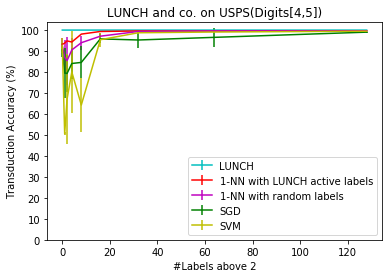

In [101]:
# The Main Experiment:
max_label_depth = min([int(math.floor(math.log(len(subset_labels), 2)) ) , 7])
num_extra = [0]
num_extra.extend([int(math.pow(2,i)) for i in range(max_label_depth + 1)])
#chc_perfs = []
active_perfs = []
knn_active_perfs = []
perfs = []
knn_perfs = []
sgd_perfs = []
svm_perfs = []
s3vm_perfs = []

do_s3vm = False

output_set = {}
for value in subset_labels:
    output_set[value] = 1
output_space = len(output_set)


for num in num_extra:
    print( 'Working on ' + str(num) )
    # Active Setting First:
    #snapshots, all_groups, s_to_a, children, parents = chc_groups(range(len(subset_labels)), edge_set)
    #chc_training_set = {index:subset_labels[index] for index in max_labeling_set(num + 10, all_groups, children)}  # + 10 is equivalent to the one guaranteed of each.
    #if len(chc_training_set) < 20:
    #    print(chc_training_set)
    #snapshots, all_groups, s_to_a, children, parents = chc_groups(range(len(subset_labels)), edge_set, chc_training_set)
    #guess_labels = bottom_up_label(snapshots, copy(chc_training_set))
    #(correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, chc_training_set)
    #chc_performance = [correct_percentage]
    
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set)
    training_set = {index:subset_labels[index] for index in max_labeling_set(num + output_space, all_groups, children)}  # + output_space means LUNCH has a chance at 1 label per category.
    if len(training_set) < 20:
        print(training_set)
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set, training_set)
    guess_labels = bottom_up_label(snapshots, copy(training_set))
    knn_labels = knn(subset_data, copy(training_set))
    (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, training_set)
    active_performance = [correct_percentage]
    print("Correct Percentage", correct_percentage)
    (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, knn_labels, training_set)
    knn_active_performance = [correct_percentage]
    
#     print(subset_data.shape, training_set)
#     X, y = labels_to_supervised_dataset(subset_data, training_set)
#     basemodel = SGDClassifier(loss='hinge', penalty='l1', tol=1e-3, max_iter=1000) # scikit sgd regression
#     basemodel.fit(X, y)
#     sgd_labels = sgd(subset_data, copy(training_set), basemodel)
    
#     (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, sgd_labels, training_set)
#     sgd_active_performance = [correct_percentage]
    
    

    performance = []
    knn_performance = []
    sgd_performance = []
    svm_performance = []
    s3vm_performance = []
    for repeat in range(5):
        training_set = training_indices(subset_labels, num) # Gives 1 for each class label + num
        if len(training_set) < 20:
            print(training_set)
        snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set, training_set)
        guess_labels = bottom_up_label(snapshots, copy(training_set))
        knn_labels = knn(subset_data, copy(training_set))
        (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, training_set)
        performance.append(correct_percentage)
        print("Correct Percentage", correct_percentage)
        (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, knn_labels, training_set)
        knn_performance.append(correct_percentage)
        
        X_supervised, y_supervised = labels_to_supervised_dataset(subset_data, training_set)
        
        
        # SGD
        basemodel = SGDClassifier(loss='hinge', penalty='l1', tol=1e-3, max_iter=1000) # scikit sgd regression
        basemodel.fit(X_supervised, y_supervised)
        sgd_labels = sgd(subset_data, copy(training_set), basemodel)

        (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, sgd_labels, training_set)
        sgd_performance.append(correct_percentage)
        
        # SVM
        kernel='rbf'
        svm = sklearn.svm.SVC(kernel=kernel, probability=True)
        svm.fit(X_supervised, y_supervised)
        svm_labels = sgd(subset_data, copy(training_set), svm)
        
        (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, svm_labels, training_set)
        svm_performance.append(correct_percentage)
        
        if do_s3vm:
            # S3VM
            ys = np.array([-1]*subset_data.shape[0])
            for k, v in training_set.items():
                ys[k] = v

            s3vm = scikitTSVM.SKTSVM(kernel=kernel)
            s3vm.fit(subset_data, ys)
            s3vm_labels = sgd(subset_data, copy(training_set), s3vm)

            (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, s3vm_labels, training_set)
            s3vm_performance.append(correct_percentage)
        
        
        
        
    #chc_perfs.append(chc_performance)
    active_perfs.append(active_performance)
    knn_active_perfs.append(knn_active_performance)
    perfs.append(performance)
    knn_perfs.append(knn_performance)
    sgd_perfs.append(sgd_performance)
    svm_perfs.append(svm_performance)
    if do_s3vm:
        s3vm_perfs.append(s3vm_performance)
#(chc_means, chc_devs, chc_errs) = series_statistics(chc_perfs)
(means, std_devs, std_errs) = series_statistics(active_perfs)
(na_means, na_std_devs, na_std_errs) = series_statistics(perfs)
(knn_act_means, knn_act_devs, knn_act_errs) = series_statistics(knn_active_perfs)
(knn_means, knn_std_devs, knn_std_errs) = series_statistics(knn_perfs)
(sgd_means, sgd_std_devs, sgd_std_errs) = series_statistics(sgd_perfs)
(svm_means, svm_std_devs, svm_std_errs) = series_statistics(svm_perfs)

if do_s3vm:
    (s3vm_means, s3vm_std_devs, s3vm_std_errs) = series_statistics(s3vm_perfs)


#plt.errorbar(num_extra, chc_means, yerr=std_devs, fmt="g", label="LUNCH with size-based snapshot rule.")
plt.errorbar(num_extra, means, yerr=std_devs, fmt="c", label="LUNCH")
#plt.errorbar(num_extra, na_means, yerr=na_std_devs, fmt="b", label="LUNCH with random labels")
plt.errorbar(num_extra, knn_act_means, yerr=knn_act_devs, fmt="r", label="1-NN with LUNCH active labels")
plt.errorbar(num_extra, knn_means, yerr=knn_std_devs, fmt="m", label="1-NN with random labels")
plt.errorbar(num_extra, sgd_means, yerr=sgd_std_devs, fmt="g", label='SGD')
plt.errorbar(num_extra, svm_means, yerr=svm_std_devs, fmt="y", label='SVM')

if do_s3vm:
    plt.errorbar(num_extra, s3vm_means, yerr=s3vm_std_devs, fmt="b", label='S3VM')
plt.yticks(np.arange(0, 100 + 1, 10.0))
plt.xlabel("#Labels above 2")
plt.ylabel("Transduction Accuracy (%)")
plt.title("LUNCH and co. on "+ active_ds +"(Digits" + dig_labels_str + ")")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#  Embedding Ablation

num_extra = [0]
num_extra.extend([int(math.pow(2,i)) for i in range(7 + 1)])
embed_perfs = []
raw_perfs = []

with open("mnist_EMST_5000_embed.pickle", "r") as file_handle:
    edge_set_embed = pickle.load(file_handle)
with open("mnist_EMST_5000.pickle", "r") as file_handle:
    edge_set_raw = pickle.load(file_handle)


for num in num_extra:
    print( 'Working on ' + str(num) )
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set_embed)
    embed_training_set = {index:subset_labels[index] for index in max_labeling_set(num + 10, all_groups, children)}
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set_embed, embed_training_set)
    guess_labels = bottom_up_label(snapshots, copy(embed_training_set))
    (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, embed_training_set)
    embed_perfs.append([correct_percentage])
    
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set_raw)
    raw_training_set = {index:subset_labels[index] for index in max_labeling_set(num + 10, all_groups, children)}
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set_raw, raw_training_set)
    guess_labels = bottom_up_label(snapshots, copy(raw_training_set))
    (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, raw_training_set)
    raw_perfs.append([correct_percentage])

(means, std_devs, std_errs) = series_statistics(embed_perfs)
(rmeans, r_devs, r_errs) = series_statistics(raw_perfs)
plt.errorbar(num_extra, means, yerr=std_devs, fmt="c", label="LUNCH on embeddings")
plt.errorbar(num_extra, rmeans, yerr=r_devs, fmt="g", label="LUNCH on raw images")

plt.xlabel("#Labels above 2")
plt.ylabel("Transduction Accuracy (%)")
plt.title("LUNCH and co. on 5000 MNIST images (embedded and not)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Extra: Showing performance of LUNCH as # Labels approaches the size of the dataset
# The Main Experiment:
max_label_depth = min([int(math.floor(math.log(len(subset_labels), 2)) ) , 15])
num_extra = [0]
num_extra.extend([int(math.pow(2,i)) for i in range(max_label_depth + 1)])
#chc_perfs = []
active_perfs = []

for num in num_extra:
    print( 'Working on ' + str(num) )
    # Active Setting First:
    #snapshots, all_groups, s_to_a, children, parents = chc_groups(range(len(subset_labels)), edge_set)
    #chc_training_set = {index:subset_labels[index] for index in max_labeling_set(num + 10, all_groups, children)}  # + 10 is equivalent to the one guaranteed of each.
    #if len(chc_training_set) < 20:
    #    print(chc_training_set)
    #snapshots, all_groups, s_to_a, children, parents = chc_groups(range(len(subset_labels)), edge_set, chc_training_set)
    #guess_labels = bottom_up_label(snapshots, copy(chc_training_set))
    #(correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, chc_training_set)
    #chc_performance = [correct_percentage]
    
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set)
    training_set = {index:subset_labels[index] for index in max_labeling_set(num + 10, all_groups, children)}  # + 10 is equivalent to the one guaranteed of each.
    if len(training_set) < 20:
        print(training_set)
    snapshots, all_groups, s_to_a, children, parents = ssc_groups(range(len(subset_labels)), edge_set, training_set)
    guess_labels = bottom_up_label(snapshots, copy(training_set))
    (correct_percentage, correct_points, incorrect_points) = score_labels(subset_data, subset_labels, guess_labels, training_set)
    active_performance = [correct_percentage]
    print("Correct Percentage", correct_percentage)

    active_perfs.append(active_performance)
(means, std_devs, std_errs) = series_statistics(active_perfs)
plt.errorbar(num_extra, means, yerr=std_devs, fmt="c", label="LUNCH")
plt.xlabel("#Labels above 10")
plt.ylabel("Transduction Accuracy (%)")
plt.title("LUNCH and co. on MNIST embeddings")
plt.legend(loc="lower right")
plt.show()